In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping

# LSTM com retroaliemntacao da saida da rede

Epoch 1/2000
16/16 [==============================] - 10s 84ms/step - loss: 1.8824 - val_loss: 1.0889
Epoch 2/2000
16/16 [==============================] - 0s 25ms/step - loss: 1.8724 - val_loss: 1.0792
Epoch 3/2000
16/16 [==============================] - 0s 21ms/step - loss: 1.8623 - val_loss: 1.0687
Epoch 4/2000
16/16 [==============================] - 0s 20ms/step - loss: 1.8511 - val_loss: 1.0573
Epoch 5/2000
16/16 [==============================] - 0s 20ms/step - loss: 1.8386 - val_loss: 1.0441
Epoch 6/2000
16/16 [==============================] - 0s 20ms/step - loss: 1.8241 - val_loss: 1.0289
Epoch 7/2000
16/16 [==============================] - 0s 16ms/step - loss: 1.8070 - val_loss: 1.0110
Epoch 8/2000
16/16 [==============================] - 0s 17ms/step - loss: 1.7867 - val_loss: 0.9893
Epoch 9/2000
16/16 [==============================] - 0s 17ms/step - loss: 1.7623 - val_loss: 0.9630
Epoch 10/2000
16/16 [==============================] - 0s 18ms/step - loss: 1.7327 - val_l

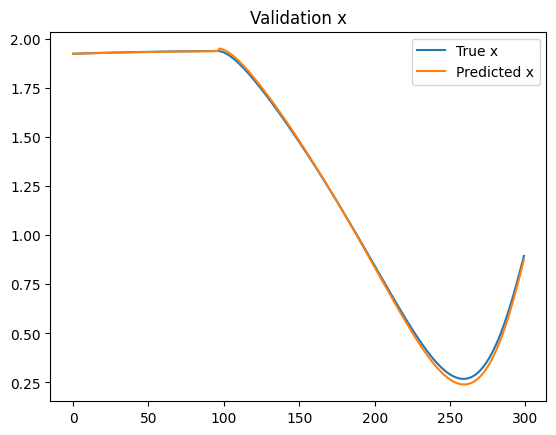

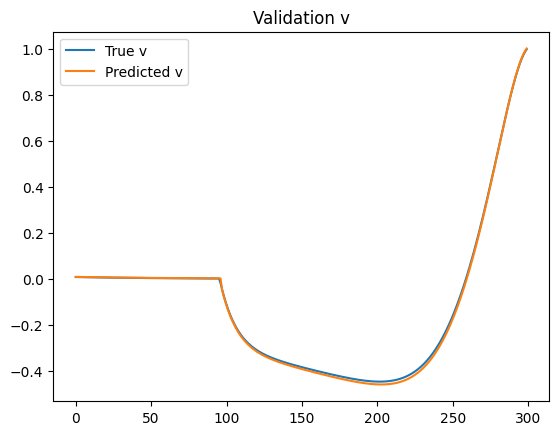

Epoch 1/2000
25/25 [==============================] - 0s 14ms/step - loss: 3.0705e-05
Epoch 2/2000
25/25 [==============================] - 0s 14ms/step - loss: 1.6822e-05
Epoch 3/2000
25/25 [==============================] - 0s 14ms/step - loss: 1.4616e-05
Epoch 4/2000
25/25 [==============================] - 0s 14ms/step - loss: 1.2232e-05
Epoch 5/2000
25/25 [==============================] - 0s 13ms/step - loss: 1.0155e-05
Epoch 6/2000
25/25 [==============================] - 0s 12ms/step - loss: 1.0935e-05
Epoch 7/2000
25/25 [==============================] - 0s 11ms/step - loss: 1.2626e-05
Epoch 8/2000
25/25 [==============================] - 0s 11ms/step - loss: 9.9883e-06
Epoch 9/2000
25/25 [==============================] - 0s 11ms/step - loss: 7.2347e-06
Epoch 10/2000
25/25 [==============================] - 0s 12ms/step - loss: 7.4291e-06
Epoch 11/2000
25/25 [==============================] - 0s 12ms/step - loss: 7.0772e-06
Epoch 12/2000
25/25 [==============================]

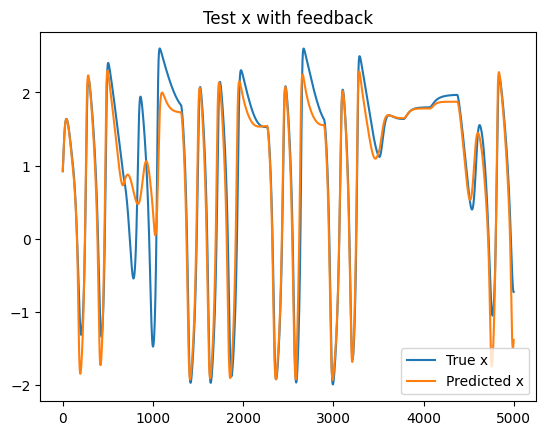

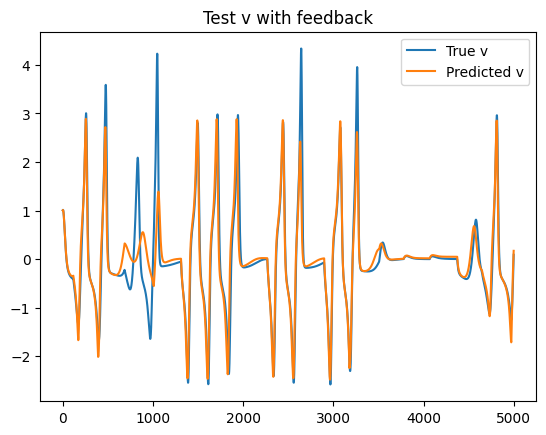

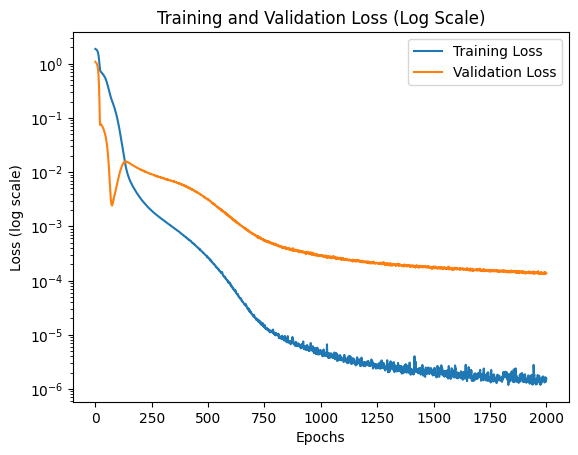

In [2]:
# Load data
input1 = np.load("input1_55.npy")
output = np.load("output_55.npy")

input1 = input1[::3]
output = output[:, ::3]
# Van der Pol oscillator parameters
mu = 1.0

# Prepare data for LSTM
X = result = np.hstack(
    (output.T[:, :], input1[:].reshape(-1, 1))
)  # Input + previous outputs
Y = output.T[1:, :]

# Reshape data for LSTM
X = X.reshape((X.shape[0], 1, X.shape[1]))
Y = Y.reshape((Y.shape[0], Y.shape[1]))


# Split data into training and validation sets
train_size = 500
val_size = 300
X_train, Y_train = X[:train_size], Y[:train_size]
X_val, Y_val = (
    X[train_size : train_size + val_size],
    Y[train_size : train_size + val_size],
)

# Define LSTM model
model = Sequential()
model.add(
    LSTM(64, activation="tanh", return_sequences=True, input_shape=(None, 3))
)  # 3 inputs: external, x and v
model.add(LSTM(64, activation="tanh", return_sequences=True))
model.add(LSTM(32, activation="tanh", return_sequences=False))
model.add(Dense(2))

# Compile model
opt = tf.keras.optimizers.Adam(learning_rate=1e-4)
model.compile(optimizer=opt, loss="mse")

# early_stopping = EarlyStopping(
#     monitor="val_loss",  # Monitor validation loss
#     patience=20,  # Stop if no improvement after 50 epochs
#     restore_best_weights=True,
#     min_delta=1e-5,
# )

# Train model
history = model.fit(
    X_train,
    Y_train,
    epochs=2000,
    validation_data=(X_val, Y_val),
    # callbacks=[early_stopping],  # Include the callback here
    verbose=1,
)

# Validation predictions
val_predictions = model.predict(X_val)

plt.figure()
plt.plot(Y_val[:, 0], label="True x")
plt.plot(val_predictions[:, 0], label="Predicted x")
plt.legend()
plt.title("Validation x")
plt.show()

plt.figure()
plt.plot(Y_val[:, 1], label="True v")
plt.plot(val_predictions[:, 1], label="Predicted v")
plt.legend()
plt.title("Validation v")
plt.show()

# Retrain with more data and test
train_size_retrain = 800
test_size = 5000
X_train_retrain, Y_train_retrain = X[:train_size_retrain], Y[:train_size_retrain]
X_test, Y_test = (
    X[train_size_retrain : train_size_retrain + test_size],
    Y[train_size_retrain : train_size_retrain + test_size],
)

# early_stopping = EarlyStopping(
#     monitor="loss",  # Monitor validation loss
#     patience=50,  # Stop if no improvement after 50 epochs
#     restore_best_weights=True,
#     min_delta=1e-5,
# )

# Retrain model
model.fit(
    X_train_retrain,
    Y_train_retrain,
    epochs=2000,
    verbose=1,
    # callbacks=[early_stopping],  # Include the callback here
)


def predict_with_feedback(model, initial_state, u_seq):
    """
    model: modelo treinado
    initial_state: vetor [x0, v0] do estado inicial
    u_seq: sequência do input externo (u) para cada novo instante (array com shape (n_steps,))
    """
    predictions = []
    current_state = initial_state.copy()  # [x, v]

    for u in u_seq:
        # Monta a entrada: [estado anterior, u_atual]
        input_vec = np.array([current_state[0], current_state[1], u])
        input_vec = input_vec.reshape(1, 1, 3)  # Formato (1, 1, 3)

        pred = model.predict(input_vec)  # Predição tem shape (1, 2)
        pred = pred[0]  # vetor [x_pred, v_pred]
        predictions.append(pred)

        # Atualiza o estado para a próxima iteração
        current_state = pred

    return np.array(predictions)


# Número de passos a previr
n_steps = X_test.shape[0]

# Estado inicial: pegue o estado do primeiro exemplo do conjunto de teste
initial_state = X_test[0, 0, :2]  # [x, v]

# Sequência de input externo para os n_steps: coluna 2 de X_test
u_seq = X_test[:, 0, 2]

# Predição com feedback
test_predictions_LSTM = predict_with_feedback(model, initial_state, u_seq)

# Plot dos resultados
plt.figure()
plt.plot(Y_test[:, 0], label="True x")
plt.plot(test_predictions_LSTM[:, 0], label="Predicted x")
plt.legend()
plt.title("Test x with feedback")
plt.show()

plt.figure()
plt.plot(Y_test[:, 1], label="True v")
plt.plot(test_predictions_LSTM[:, 1], label="Predicted v")
plt.legend()
plt.title("Test v with feedback")
plt.show()

# Extract loss values
train_loss = history.history["loss"]
val_loss = history.history.get("val_loss", None)  # Validation loss (if available)

# Plot the loss curves with log scale
plt.figure()
plt.plot(train_loss, label="Training Loss")
if val_loss:
    plt.plot(val_loss, label="Validation Loss")
plt.yscale("log")  # Set y-axis to logarithmic scale
plt.xlabel("Epochs")
plt.ylabel("Loss (log scale)")
plt.legend()
plt.title("Training and Validation Loss (Log Scale)")
plt.show()

# PI-LSTM com physics loss

Epoch 1/2000
16/16 [==============================] - 6s 98ms/step - loss: 2.0445 - val_loss: 1.2512
Epoch 2/2000
16/16 [==============================] - 0s 21ms/step - loss: 2.0385 - val_loss: 1.2433
Epoch 3/2000
16/16 [==============================] - 0s 21ms/step - loss: 2.0322 - val_loss: 1.2353
Epoch 4/2000
16/16 [==============================] - 0s 21ms/step - loss: 2.0255 - val_loss: 1.2268
Epoch 5/2000
16/16 [==============================] - 0s 21ms/step - loss: 2.0182 - val_loss: 1.2174
Epoch 6/2000
16/16 [==============================] - 0s 21ms/step - loss: 2.0099 - val_loss: 1.2068
Epoch 7/2000
16/16 [==============================] - 0s 23ms/step - loss: 2.0002 - val_loss: 1.1950
Epoch 8/2000
16/16 [==============================] - 0s 21ms/step - loss: 1.9891 - val_loss: 1.1810
Epoch 9/2000
16/16 [==============================] - 0s 21ms/step - loss: 1.9761 - val_loss: 1.1646
Epoch 10/2000
16/16 [==============================] - 0s 21ms/step - loss: 1.9608 - val_lo

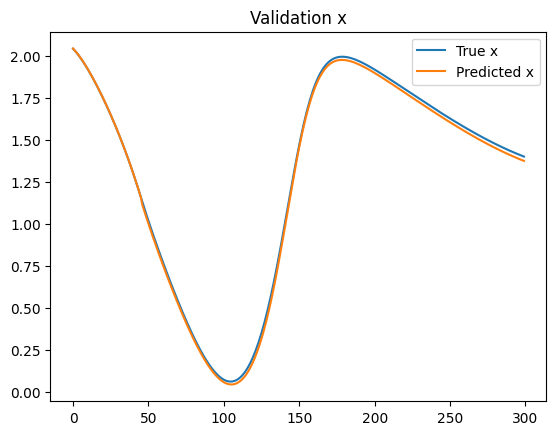

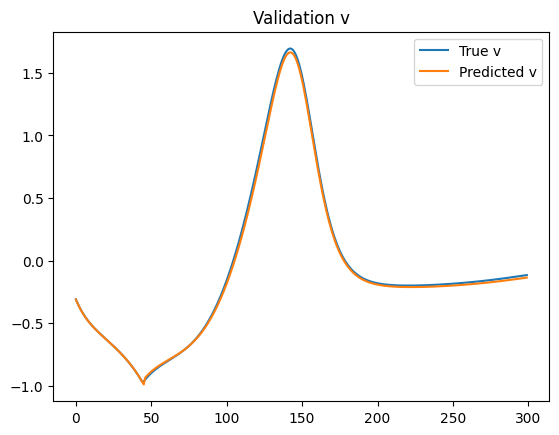

Epoch 1/2000
25/25 [==============================] - 3s 18ms/step - loss: 1.2105e-04
Epoch 2/2000
25/25 [==============================] - 0s 15ms/step - loss: 8.3173e-05
Epoch 3/2000
25/25 [==============================] - 0s 14ms/step - loss: 7.9778e-05
Epoch 4/2000
25/25 [==============================] - 0s 13ms/step - loss: 7.8436e-05
Epoch 5/2000
25/25 [==============================] - 0s 11ms/step - loss: 7.8477e-05
Epoch 6/2000
25/25 [==============================] - 0s 14ms/step - loss: 7.5410e-05
Epoch 7/2000
25/25 [==============================] - 0s 12ms/step - loss: 7.2405e-05
Epoch 8/2000
25/25 [==============================] - 0s 11ms/step - loss: 7.8935e-05
Epoch 9/2000
25/25 [==============================] - 0s 14ms/step - loss: 7.3310e-05
Epoch 10/2000
25/25 [==============================] - 0s 12ms/step - loss: 7.3807e-05
Epoch 11/2000
25/25 [==============================] - 0s 13ms/step - loss: 7.3354e-05
Epoch 12/2000
25/25 [==============================]

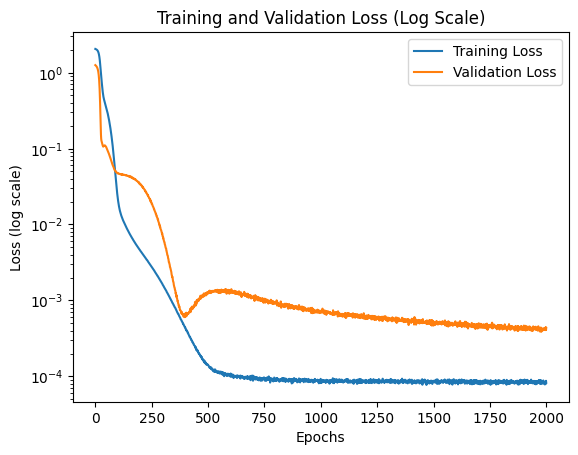

1/1 [==============================] - 0s 31ms/step


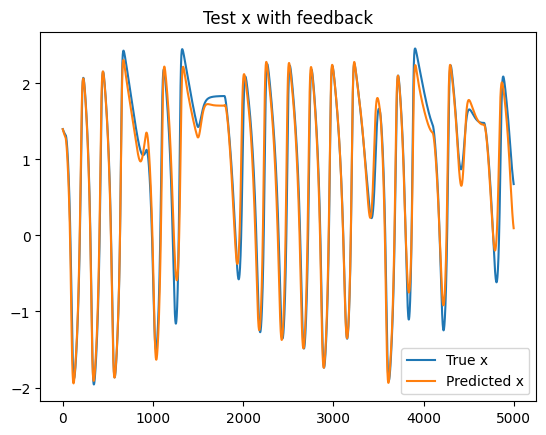

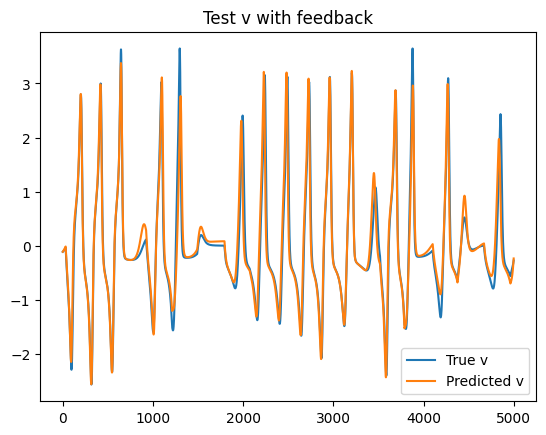

In [4]:
# Carregar dados
input1 = np.load("input1.npy")
output = np.load("output.npy")

input1 = input1[::3]
output = output[:, ::3]

# Parâmetro do oscilador de Van der Pol
mu = 1.0

# Preparação dos dados para a LSTM
X = np.hstack((output.T[:, :], input1[:].reshape(-1, 1)))  # Entrada: x, v, u
Y = output.T[1:, :]

# Reformatar os dados para LSTM
X = X.reshape((X.shape[0], 1, X.shape[1]))
Y = Y.reshape((Y.shape[0], Y.shape[1]))

# Divisão dos dados em treino e validação
train_size = 500
val_size = 300
X_train, Y_train = X[:train_size], Y[:train_size]
X_val, Y_val = (
    X[train_size : train_size + val_size],
    Y[train_size : train_size + val_size],
)

# early_stopping = EarlyStopping(
#     monitor="val_loss",  # Monitor validation loss
#     patience=20,  # Stop if no improvement after 50 epochs
#     restore_best_weights=True,  # Restore best model weights
# )


def physics_loss(u_data):
    """
    Função de perda que recebe u_data como argumento.
    """

    def loss(y_true, y_pred):
        dt = 0.3
        mu = 1.0

        loss_data = tf.reduce_mean(tf.square(y_true - y_pred))

        h1, h2 = tf.split(y_pred, num_or_size_splits=2, axis=1)

        error_phy_x = h1[1:] - (h1[:-1] + dt * h2[:-1])
        mse_phy_x = tf.reduce_mean(tf.square(error_phy_x))

        error_phy_v = h2[1:] - (
            h2[:-1]
            + dt * (mu * (1 - tf.square(h1[:-1])) * h2[:-1] - h1[:-1] + u_data[:-1])
        )
        mse_phy_v = tf.reduce_mean(tf.square(error_phy_v))

        loss_total = loss_data + (mse_phy_x + mse_phy_v) * 1e-5  # 5e-4
        return loss_total

    return loss


# Criar o modelo
model = Sequential(
    [
        LSTM(64, activation="tanh", return_sequences=True, input_shape=(None, 3)),
        LSTM(64, activation="tanh", return_sequences=True),
        LSTM(32, activation="tanh", return_sequences=False),
        Dense(2),
    ]
)

# Compilar o modelo
opt = tf.keras.optimizers.Adam(learning_rate=1e-4)
model.compile(optimizer=opt, loss=physics_loss(X_train[:, 0, 2]))

# Treinar o modelo
history = model.fit(
    X_train,
    Y_train,
    epochs=2000,
    validation_data=(X_val, Y_val),
    verbose=1,
    # callbacks=[early_stopping],
)

# Fazer previsões na validação
val_predictions = model.predict(X_val)

plt.figure()
plt.plot(Y_val[:, 0], label="True x")
plt.plot(val_predictions[:, 0], label="Predicted x")
plt.legend()
plt.title("Validation x")
plt.show()

plt.figure()
plt.plot(Y_val[:, 1], label="True v")
plt.plot(val_predictions[:, 1], label="Predicted v")
plt.legend()
plt.title("Validation v")
plt.show()

# Teste final com mais dados
train_size_retrain = 800
test_size = 5000
X_train_retrain, Y_train_retrain = X[:train_size_retrain], Y[:train_size_retrain]
X_test, Y_test = (
    X[train_size_retrain : train_size_retrain + test_size],
    Y[train_size_retrain : train_size_retrain + test_size],
)

model.compile(optimizer=opt, loss=physics_loss(X_train_retrain[:, 0, 2]))

# early_stopping = EarlyStopping(
#     monitor="loss",  # Monitor validation loss
#     patience=20,  # Stop if no improvement after 50 epochs
#     restore_best_weights=True,  # Restore best model weights
# )

# Re-treinar com mais dados
model.fit(
    X_train_retrain,
    Y_train_retrain,
    epochs=2000,
    # batch_size=32,
    verbose=1,
    # callbacks=[early_stopping],
)


def predict_with_feedback(model, initial_state, u_seq):
    """
    model: modelo treinado
    initial_state: vetor [x0, v0] do estado inicial
    u_seq: sequência do input externo (u) para cada novo instante (array com shape (n_steps,))
    """
    predictions = []
    current_state = initial_state.copy()  # [x, v]

    for u in u_seq:
        # Monta a entrada: [estado anterior, u_atual]
        input_vec = np.array([current_state[0], current_state[1], u])
        input_vec = input_vec.reshape(1, 1, 3)  # Formato (1, 1, 3)

        pred = model.predict(input_vec)  # Predição tem shape (1, 2)
        pred = pred[0]  # vetor [x_pred, v_pred]
        predictions.append(pred)

        # Atualiza o estado para a próxima iteração
        current_state = pred

    return np.array(predictions)


# Extract loss values
train_loss = history.history["loss"]
val_loss = history.history.get("val_loss", None)  # Validation loss (if available)

# Plot the loss curves with log scale
plt.figure()
plt.plot(train_loss, label="Training Loss")
if val_loss:
    plt.plot(val_loss, label="Validation Loss")
plt.yscale("log")  # Set y-axis to logarithmic scale
plt.xlabel("Epochs")
plt.ylabel("Loss (log scale)")
plt.legend()
plt.title("Training and Validation Loss (Log Scale)")
plt.show()

# Número de passos a previr
n_steps = X_test.shape[0]

# Estado inicial: pegue o estado do primeiro exemplo do conjunto de teste
initial_state = X_test[0, 0, :2]  # [x, v]

# Sequência de input externo para os n_steps: coluna 2 de X_test
u_seq = X_test[:, 0, 2]

# Predição com feedback
test_predictions_PI_LSTM = predict_with_feedback(model, initial_state, u_seq)

# Plot dos resultados
plt.figure()
plt.plot(Y_test[:, 0], label="True x")
plt.plot(test_predictions_PI_LSTM[:, 0], label="Predicted x")
plt.legend()
plt.title("Test x with feedback")
plt.show()

plt.figure()
plt.plot(Y_test[:, 1], label="True v")
plt.plot(test_predictions_PI_LSTM[:, 1], label="Predicted v")
plt.legend()
plt.title("Test v with feedback")
plt.show()


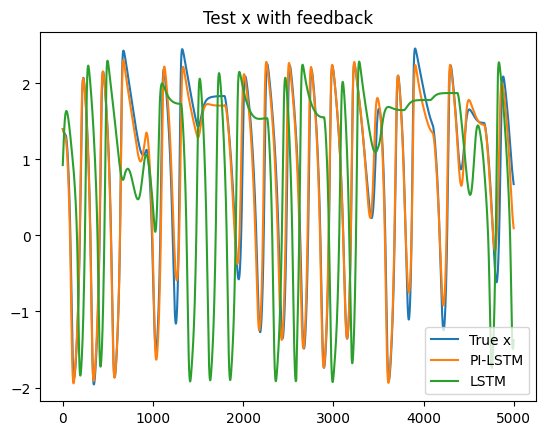

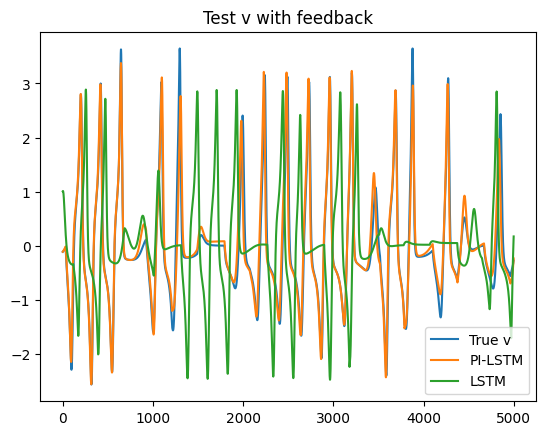

In [5]:
# Plot dos resultados
plt.figure()
plt.plot(Y_test[:, 0], label="True x")
plt.plot(test_predictions_PI_LSTM[:, 0], label="PI-LSTM")
plt.plot(test_predictions_LSTM[:, 0], label="LSTM")
plt.legend()
plt.title("Test x with feedback")
plt.show()

plt.figure()
plt.plot(Y_test[:, 1], label="True v")
plt.plot(test_predictions_PI_LSTM[:, 1], label="PI-LSTM")
plt.plot(test_predictions_LSTM[:, 1], label="LSTM")
plt.legend()
plt.title("Test v with feedback")
plt.show()

In [6]:
tf.reduce_mean(tf.square(Y_test[:, 0] - test_predictions_PI_LSTM[:, 0]))


<tf.Tensor: shape=(), dtype=float64, numpy=0.06152156120960876>

In [7]:
np.sum((test_predictions_PI_LSTM[:, 1] - Y_test[:, 1]) ** 2) / 5000

0.11462362884270244

In [8]:
np.sum((test_predictions_LSTM[:, 0] - Y_test[:, 0]) ** 2) / 5000


3.1252845470044535

In [9]:
np.sum((test_predictions_LSTM[:, 1] - Y_test[:, 1]) ** 2) / 5000

2.240406773150627

In [10]:
np.save("prediction_LSTM_2_55.npy", test_predictions_LSTM)
np.save("prediction_PI_LSTM_2_55.npy", test_predictions_PI_LSTM)